Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# Import libs
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import math
from math import nan
import random
import json
from future.utils import iteritems
import pickle
from requests import get

# Needed for using CRF
!pip install git+https://www.github.com/keras-team/keras-contrib.git

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input
# from keras.layers import CuDNNLSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-1osqmflr
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-1osqmflr
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=3a3ed19ad09b45116848f05518fa646a41422e9fda852151ea68bd48183b45bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-zytk9rep/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


Using TensorFlow backend.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=af8b331d0e4e5a3b2c88f0fc17963c1a6ae3d84a4b82250d54745b04c6e28c08
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1iTLWWB9aFjtjVz7Kq4ku2syjhINCz2_q'
DATA_TRAINING_FILENAME = 'ner_medical_training.csv'
DATA_DEV_FILE_ID = '1fB1Mp-6_zxGC3NO5sMX23B-LPyYzc9I9'
DATA_DEV_FILENAME = 'ner_medical_dev.csv'
DATA_TEST_FILE_ID = '17vmu2VXPwvOKuQ66kDY7t38dFqkYccvx'
DATA_TEST_FILENAME = 'ner_medical_test.csv'
BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [3]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1000
Number of dev sentences:  1000
Number of test sentences:  1000
Number of words in the training dataset:  10405
Number of words in the dev dataset:  10246
Number of words in the test dataset:  10814
Tags in the training dataset: ['B-Disease', 'I-Disease', 'B-Chemical', 'I-Chemical', 'O']
Number of Labels in the training dataset:  5
Tags in the dev dataset: ['B-Disease', 'I-Disease', 'B-Chemical', 'I-Chemical', 'O']
Number of Labels in the dev dataset:  5
Tags in the test dataset: ['B-Disease', 'I-Disease', 'B-Chemical', 'I-Chemical', 'O']
Number of Labels in the test dataset:  5
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Naloxone,B-Chemical
1,Sentence: 1,reverses,O
2,Sentence: 1,the,O
3,Sentence: 1,antihypertensive,O
4,Sentence: 1,effect,O
5,Sentence: 1,of,O
6,Sentence: 1,clonidine,B-Chemical
7,Sentence: 1,.,O
8,Sentence: 2,In,O
9,Sentence: 2,unanesthetized,O


In [4]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Intravenous', 'O'),
 ('administration', 'O'),
 ('of', 'O'),
 ('prochlorperazine', 'B-Chemical'),
 ('by', 'O'),
 ('15', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('infusion', 'O'),
 ('versus', 'O'),
 ('2', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('bolus', 'O'),
 ('does', 'O'),
 ('not', 'O'),
 ('affect', 'O'),
 ('the', 'O'),
 ('incidence', 'O'),
 ('of', 'O'),
 ('akathisia', 'B-Disease'),
 (':', 'O'),
 ('a', 'O'),
 ('prospective', 'O'),
 (',', 'O'),
 ('randomized', 'O'),
 (',', 'O'),
 ('controlled', 'O'),
 ('trial', 'O'),
 ('.', 'O')]

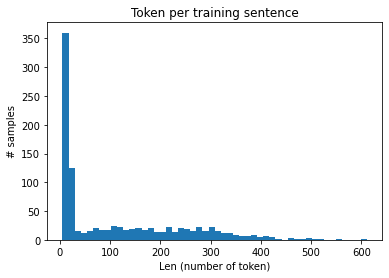

In [5]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

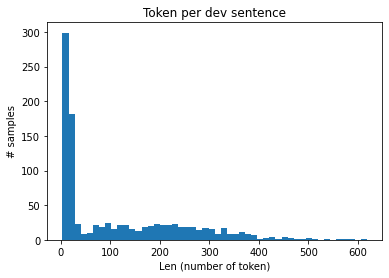

In [6]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

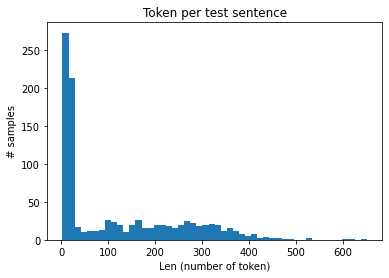

In [7]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [8]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'delirium'
print(word2idx['delirium'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Chemical'
print(tag2idx['B-Chemical'])
# Tag of index 4
print(idx2tag[4])

12802
hyperkinesia
2
O


In [9]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [10]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = math.ceil(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.5)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1000
Points in y_train before removal: 1000
Points in X_train before removal: 500
Points in y_train before removal: 500


In [11]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [12]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['delirium'])
print(tag2idx['B-Chemical'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[6369, 5779, 2436, 16592, 6721, 11855, 14861, 9676, 8221, 8782, 7078, 7987, 13346, 18502, 6309, 14861, 10719, 3962, 3945, 14702, 12235, 14352, 14771, 18389, 107, 14352, 13060, 6316, 9941, 10410, 14771, 2960, 9869, 4174, 3722, 4174, 4575, 10742, 4174, 14771, 107, 6214, 8583, 528, 16951, 13060, 11559, 14212, 3575, 14683, 8495, 18502, 2055, 126, 15431, 3622, 5097, 12673, 6150, 3945, 5645, 15431, 6721, 11855, 7539, 4059, 4275, 1697, 10742, 15431, 13346, 18502, 6309, 18502, 12579, 8221, 8782, 3945]
[4, 4, 4, 4, 2, 3, 4, 4, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 4]
[17107, 5291, 14241, 14771, 16120, 11078, 12899, 3575, 14683, 17767, 1863, 3945]
[0, 1, 1, 4, 2, 3, 0, 4, 4, 4, 4, 4]
[1624, 18502, 4482, 12802, 3945, 6369, 11396, 15431, 15722, 1523, 3945]
[2, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4]
12802
2
B-Chemical
affect
18533
5


In [13]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 1.x
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import CuDNNLSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['delirium'])
print(tag2idx['B-Chemical'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-zp423it9
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-zp423it9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[6369, 5779, 2436, 16592, 6721, 11855, 14861, 9676, 8221, 8782, 7078, 7987, 13346, 18502, 6309, 14861, 10719, 3962, 3945, 14702, 12235, 14352, 14771, 18389, 107, 14352, 13060, 6316, 9941, 10410, 14771, 2960, 9869, 4174, 3722, 4174, 4575, 10742, 4174, 14771, 107, 6214, 8583, 528, 16951, 13060, 11559, 14212, 3575, 14683, 8495, 18502, 2055, 126, 15431, 3622, 5097, 12673, 6150, 3945, 5645, 15431, 6721, 11855, 7539, 4059, 4275, 1697, 10742, 15431, 13346, 18502, 6309, 18502, 12579, 8221, 8782, 3945]
[4, 4, 4, 4, 2, 3, 4, 4, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [14]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [15]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [16]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['crf_viterbi_accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [17]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [18]:
# Model creation function
def create_model(maxlen, n_words):
  input = Input(shape=(maxlen,))
  word_embedding_size = 150

  model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
  model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5))(model)
  model = TimeDistributed(Dense(n_tags,
                                activation="relu"))(model)  
  crf = CRF(n_tags)
  out = crf(model)
  model = Model(input, out)

  adam = k.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
  model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
  model.summary()

  return model

In [19]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.0001, verbose=1)
  callbacks_list = [early_stopping]

  history = model.fit(X_train_df, np.array(y_train_df), batch_size=math.ceil(0.05*len(X_train_df)), epochs=100, validation_data=(X_dev_df,  np.array(y_dev_df)), verbose=1, callbacks=callbacks_list)
  plot_history(history)

In [20]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [21]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=n_words - 1)
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=n_words - 1)
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=n_words - 1)

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  model = None
  model = create_model(maxlen, n_words)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_1 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________

Train on 500 samples

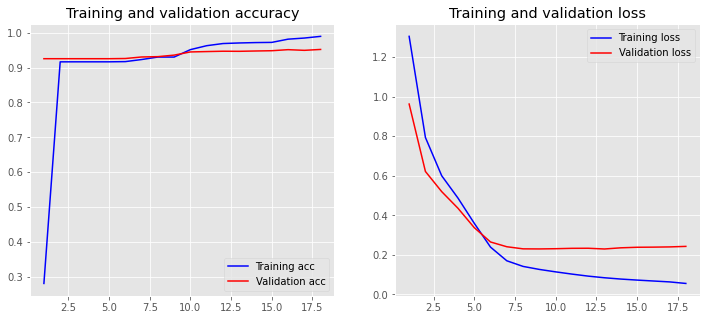

1000/1000 [==============================] - 16s 16ms/step
F1-score: 47.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8433785019536121,0.4998029362498768,0.627648714696693,20298.0
Disease,0.458819913952059,0.17493702032925185,0.25329770539084695,17069.0
micro avg,0.708367049684415,0.3514063210854497,0.46976960503720666,37367.0
macro avg,0.6510992079528355,0.33736997828956433,0.44047321004377,37367.0
weighted avg,0.6677146665213186,0.3514063210854497,0.45664763412181447,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_2 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 500 samples, validate on 1000 samples
Epoch 1/100
500/500 [==============================] - 56s 112ms/ste

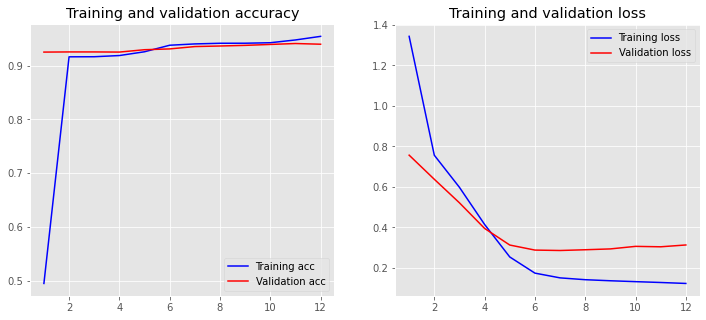

1000/1000 [==============================] - 16s 16ms/step
F1-score: 20.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.16900609669644123,0.05872499753670312,0.08716317502102298,20298.0
Disease,0.31599699586932034,0.29579940242544966,0.3055648016461403,17069.0
micro avg,0.2709825886848161,0.16701902748414377,0.20666247226729365,37367.0
macro avg,0.2425015462828808,0.1772621999810764,0.19636398833358165,37367.0
weighted avg,0.2361505733197151,0.16701902748414377,0.18692760258716765,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_3 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 500 samples, validate on 1000 samples
Epoch 1/100
500/500 [==============================] - 56s 112ms/ste

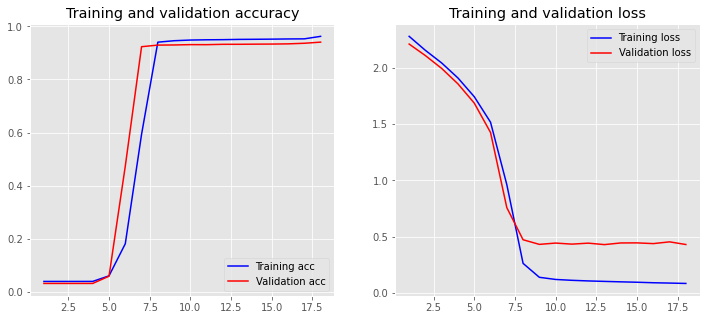

1000/1000 [==============================] - 16s 16ms/step
F1-score: 29.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.49055232558139533,0.06650901566656814,0.11713665943600869,20298.0
Disease,0.32782520166027096,0.49047981721249045,0.3929870678527002,17069.0
micro avg,0.343655001767409,0.2601760912034683,0.29614511780922065,37367.0
macro avg,0.4091887636208331,0.2784944164395293,0.25506186364435446,37367.0
weighted avg,0.41621964492173114,0.2601760912034683,0.24314331293413557,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_4 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 500 samples, validate on 1000 samples
Epoch 1/100
500/500 [==============================] - 56s 112ms/ste

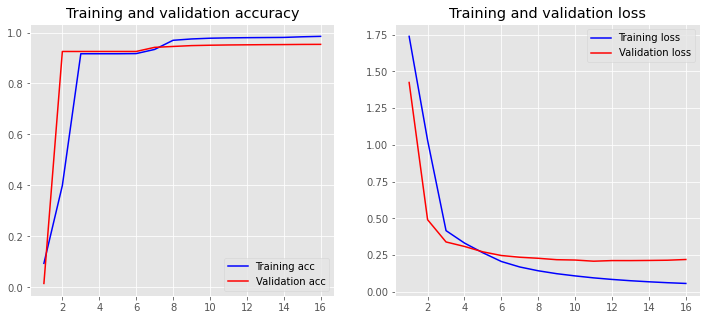

1000/1000 [==============================] - 16s 16ms/step
F1-score: 51.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7818898246156224,0.49857128781160703,0.6088866159261154,20298.0
Disease,0.5125324916450056,0.3234518718144004,0.39660931719406634,17069.0
micro avg,0.659540375289901,0.4185778895817165,0.512131233423922,37367.0
macro avg,0.6472111581303139,0.41101157981300374,0.5027479665600909,37367.0
weighted avg,0.658849165304587,0.4185778895817165,0.5119197410884955,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_5 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 500 samples, validate on 1000 samples
Epoch 1/100
500/500 [==============================] - 56s 113ms/ste

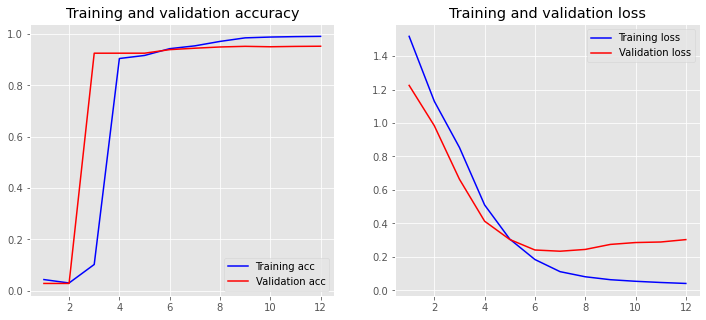

1000/1000 [==============================] - 17s 17ms/step
F1-score: 41.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7005551950392963,0.4786678490491674,0.5687359147715633,20298.0
Disease,0.6290496760259179,0.06825238736891441,0.1231435970614661,17069.0
micro avg,0.692131543794924,0.2911927636684775,0.4099231464737794,37367.0
macro avg,0.6648024355326071,0.2734601182090409,0.3459397559165147,37367.0
weighted avg,0.6678919439343278,0.2911927636684775,0.36519227276140326,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_6 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 500 samples, validate on 1000 samples
Epoch 1/100
500/500 [==============================] - 57s 115ms/ste

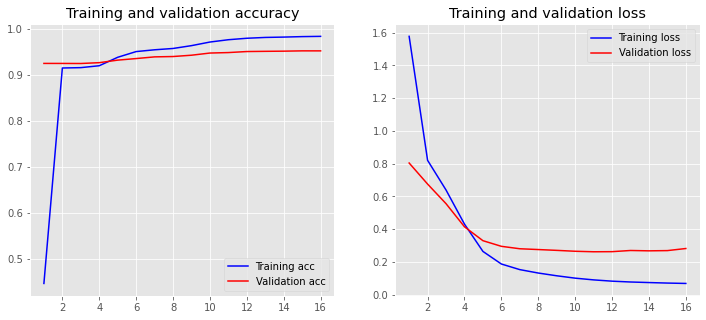

1000/1000 [==============================] - 17s 17ms/step
F1-score: 49.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8938083411835231,0.5141885900088679,0.6528225175918686,20298.0
Disease,0.41226005070626587,0.266740875270959,0.32390708924696754,17069.0
micro avg,0.6597420888165133,0.4011561003024059,0.4989348954866197,37367.0
macro avg,0.6530341959448945,0.39046473263991344,0.48836480341941807,37367.0
weighted avg,0.6738402471391443,0.4011561003024059,0.502576111768037,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_7 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 500 samples, validate on 1000 samples
Epoch 1/100
500/500 [==============================] - 57s 113ms/ste

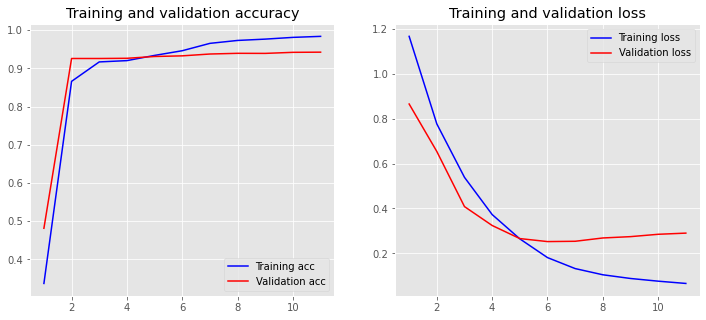

1000/1000 [==============================] - 17s 17ms/step
F1-score: 29.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3165337498972293,0.18967385949354615,0.23720772619451033,20298.0
Disease,0.4211414544338754,0.3216357138672447,0.3647234678624813,17069.0
micro avg,0.3706496289535299,0.24995316723312014,0.2985647156602627,37367.0
macro avg,0.3688376021655524,0.25565478668039543,0.3009655970284958,37367.0
weighted avg,0.3643178617803351,0.24995316723312014,0.2954560788728253,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_8 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 500 samples, validate on 1000 samples
Epoch 1/100
500/500 [==============================] - 58s 115ms/ste

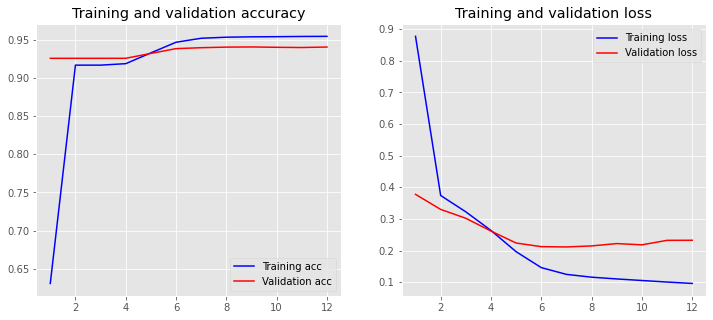

1000/1000 [==============================] - 17s 17ms/step
F1-score: 34.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6584032354703415,0.43309685683318555,0.5224962852897475,20298.0
Disease,0.24313725490196078,0.0072646317886226495,0.014107742192388644,17069.0
micro avg,0.643125090174578,0.23857949527658093,0.3480450526069218,37367.0
macro avg,0.45077024518615116,0.2201807443109041,0.26830201374106805,37367.0
weighted avg,0.46871246494229024,0.23857949527658093,0.29026774025993995,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_9 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 500 samples, validate on 1000 samples
Epoch 1/100
500/500 [==============================] - 57s 114ms/ste

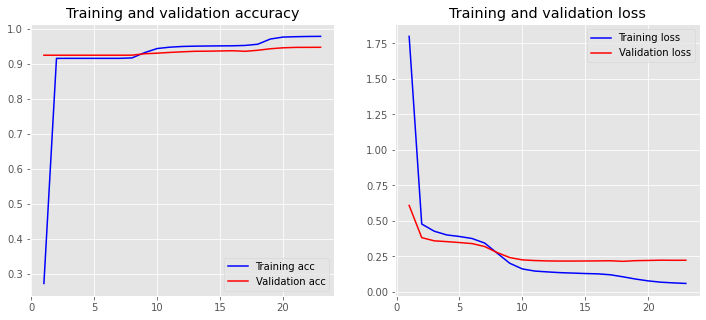

1000/1000 [==============================] - 17s 17ms/step
F1-score: 39.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5429726368159205,0.4301409005813381,0.48001539391940184,20298.0
Disease,0.3601605985947623,0.2312379166910774,0.2816469245040674,17069.0
micro avg,0.46887828691889494,0.33928332485883267,0.39369002887929694,37367.0
macro avg,0.45156661770534134,0.33068940863620777,0.3808311592117346,37367.0
weighted avg,0.4594652993149986,0.33928332485883267,0.3894019808958692,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_10 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 500 samples, validate on 1000 samples
Epoch 1/100
500/500 [==============================] - 57s 114ms/st

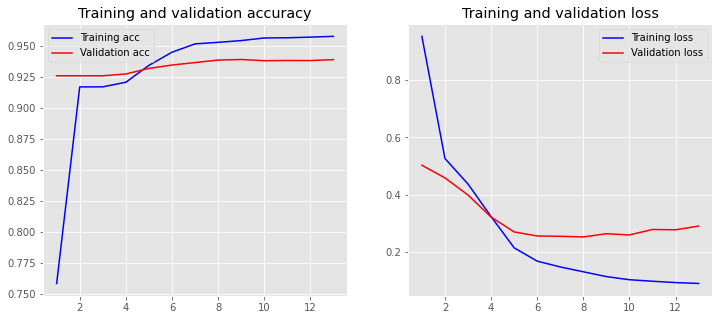

1000/1000 [==============================] - 18s 18ms/step
F1-score: 32.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.4093302923491603,0.48630406936644005,0.4445094904645036,20298.0
Disease,0.010526315789473684,5.8585740230827815e-05,0.00011652295502213935,17069.0
micro avg,0.4077653862040479,0.26419032836459977,0.3206391997011871,37367.0
macro avg,0.20992830406931698,0.24318132755333544,0.22231300670976287,37367.0
weighted avg,0.22715925705338352,0.26419032836459977,0.2415137037430826,37367.0



In [22]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_11 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 625 samples, validate on 1000 samples
Epoch 1/100
625/625 [==============================] - 52s 83ms/ste

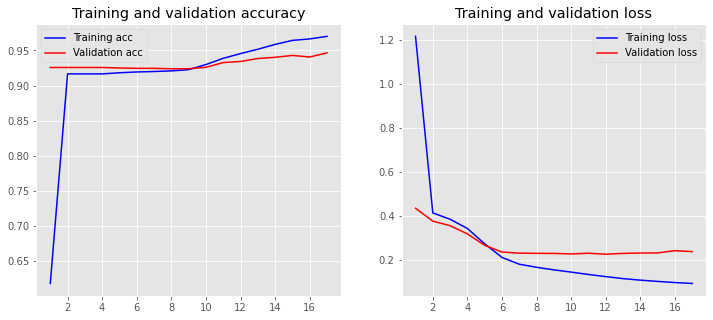

1000/1000 [==============================] - 18s 18ms/step
F1-score: 28.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3193030097307083,0.0695142378559464,0.11417243192944128,20298.0
Disease,0.46007921617677716,0.387896186068311,0.42091544818817545,17069.0
micro avg,0.42700691121743756,0.21494901918805362,0.28595332609430907,37367.0
macro avg,0.3896911129537427,0.2287052119621287,0.2675439400588084,37367.0
weighted avg,0.38360865556334006,0.21494901918805362,0.25429062564369004,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_12 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 625 samples, validate on 1000 samples
Epoch 1/100
625/625 [==============================] - 53s 85ms/ste

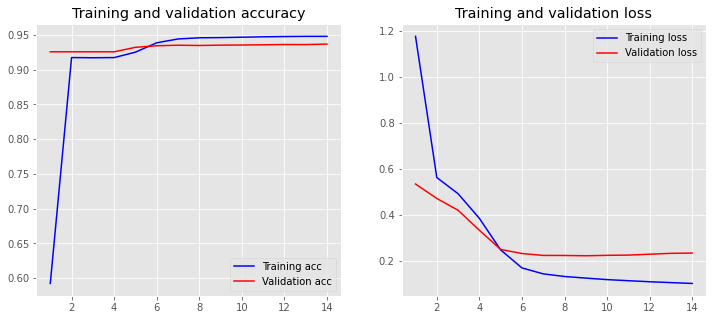

1000/1000 [==============================] - 18s 18ms/step
F1-score: 26.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6484848484848484,0.00527145531579466,0.01045789962371109,20298.0
Disease,0.3078648433543159,0.4985646493643447,0.3806669499675695,17069.0
micro avg,0.30988599992807564,0.23060454411646641,0.26443060115997175,37367.0
macro avg,0.47817484591958215,0.2519180523400697,0.1955624247956403,37367.0
weighted avg,0.4928918689153604,0.23060454411646641,0.1795669605683767,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_13 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 625 samples, validate on 1000 samples
Epoch 1/100
625/625 [==============================] - 52s 83ms/ste

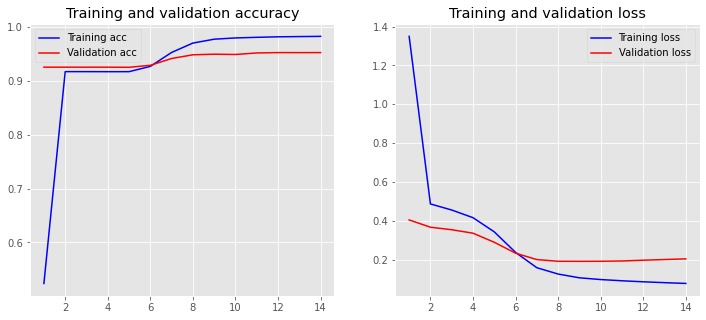

1000/1000 [==============================] - 18s 18ms/step
F1-score: 55.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.759607271611567,0.48788057936742535,0.5941502924853757,20298.0
Disease,0.6271112658889082,0.42199308688265275,0.5045000875503415,17069.0
micro avg,0.6975492394894589,0.45778360585543393,0.5527872031022782,37367.0
macro avg,0.6933592687502377,0.4549368331250391,0.5493251900178586,37367.0
weighted avg,0.6990839670465747,0.45778360585543393,0.5531986681099615,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_14 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_14 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 625 samples, validate on 1000 samples
Epoch 1/100
625/625 [==============================] - 52s 83ms/ste

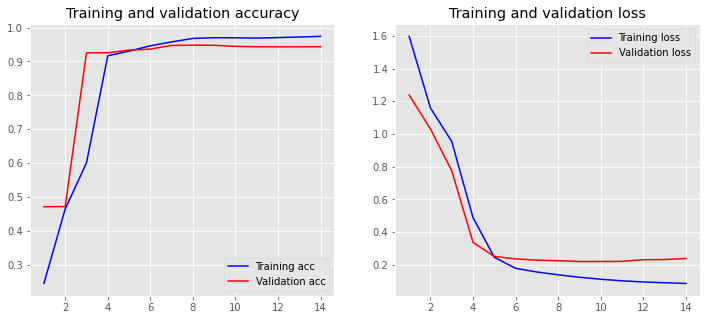

1000/1000 [==============================] - 18s 18ms/step
F1-score: 47.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5696045197740113,0.496699182185437,0.5306595083951787,20298.0
Disease,0.6190654672663668,0.2902923428437518,0.3952458820244885,17069.0
micro avg,0.5850062247121071,0.40241389461289373,0.4768277021134912,37367.0
macro avg,0.594334993520189,0.3934957625145944,0.4629526952098336,37367.0
weighted avg,0.592197955499304,0.40241389461289373,0.46880345389464856,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_15 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 625 samples, validate on 1000 samples
Epoch 1/100
625/625 [==============================] - 53s 85ms/ste

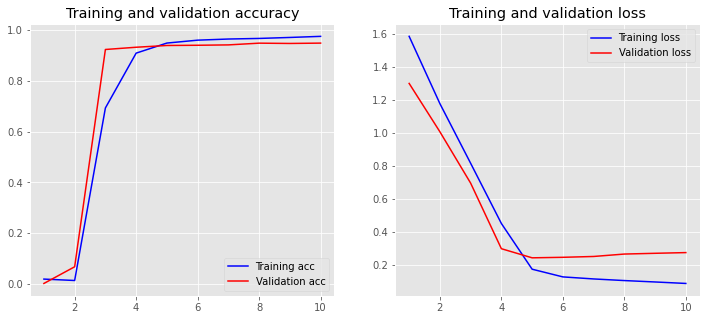

1000/1000 [==============================] - 19s 19ms/step
F1-score: 32.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.431547072857405,0.4633954084146221,0.4469045469663135,20298.0
Disease,0.2652782519631273,0.045521120159353216,0.07770777077707772,17069.0
micro avg,0.41185035389282104,0.27251318007867903,0.3279971654963602,37367.0
macro avg,0.34841266241026614,0.25445826428698765,0.2623061588716956,37367.0
weighted avg,0.3555965682987189,0.27251318007867903,0.2782578862021616,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_16 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_16 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 625 samples, validate on 1000 samples
Epoch 1/100
625/625 [==============================] - 53s 84ms/ste

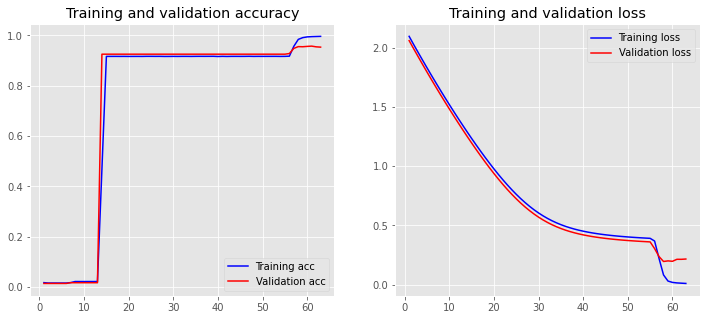

1000/1000 [==============================] - 19s 19ms/step
F1-score: 60.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9207004033736707,0.49477781062173615,0.6436582708453503,20298.0
Disease,0.6006805444355484,0.5274474192981429,0.5616869950400849,17069.0
micro avg,0.7354803830707445,0.509701073139401,0.6021213031313721,37367.0
macro avg,0.7606904739046095,0.5111126149599395,0.6026726329427177,37367.0
weighted avg,0.774517435187442,0.509701073139401,0.6062143308255448,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_17 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 625 samples, validate on 1000 samples
Epoch 1/100
625/625 [==============================] - 52s 83ms/ste

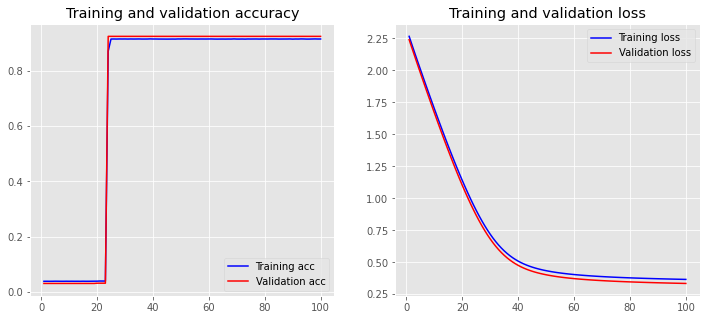

1000/1000 [==============================] - 19s 19ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_18 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 625 samples, validate on 1000 samples
Epoch 1/100
625/625 [==============================] - 52s 83ms/ste

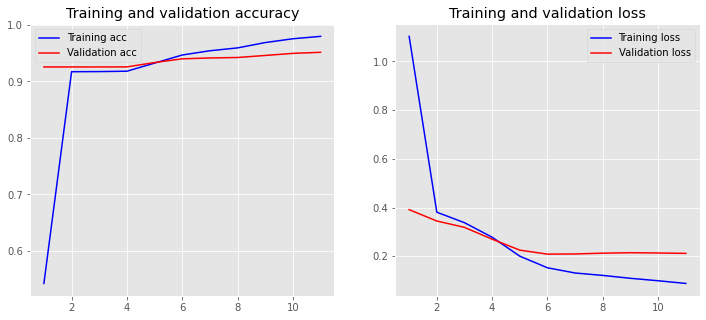

1000/1000 [==============================] - 19s 19ms/step
F1-score: 32.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.44656074678232993,0.46664696029165437,0.45638295309450966,20298.0
Disease,0.125,0.0007616146230007616,0.001514004542013626,17069.0
micro avg,0.44499178981937604,0.25383359648888054,0.32326778228417574,37367.0
macro avg,0.28578037339116497,0.23370428745732758,0.22894847881826164,37367.0
weighted avg,0.2996739111565749,0.25383359648888054,0.24860180708753682,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_19 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 625 samples, validate on 1000 samples
Epoch 1/100
625/625 [==============================] - 53s 85ms/ste

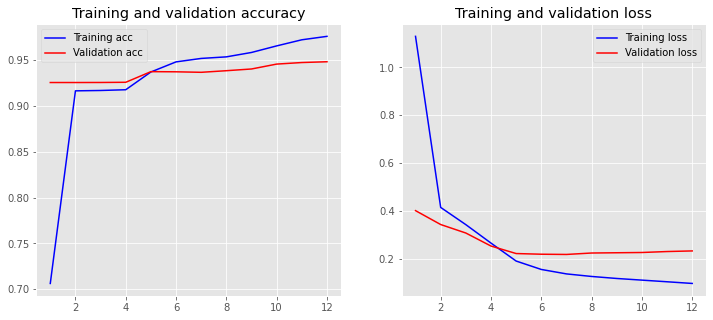

1000/1000 [==============================] - 19s 19ms/step
F1-score: 32.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.433463314060329,0.4764508818602818,0.4539416555187872,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.4332303005868387,0.2588112505686836,0.32404087786898983,37367.0
macro avg,0.2167316570301645,0.2382254409301409,0.2269708277593936,37367.0
weighted avg,0.23546012119775628,0.2588112505686836,0.24658409087484526,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_20 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 625 samples, validate on 1000 samples
Epoch 1/100
625/625 [==============================] - 53s 85ms/ste

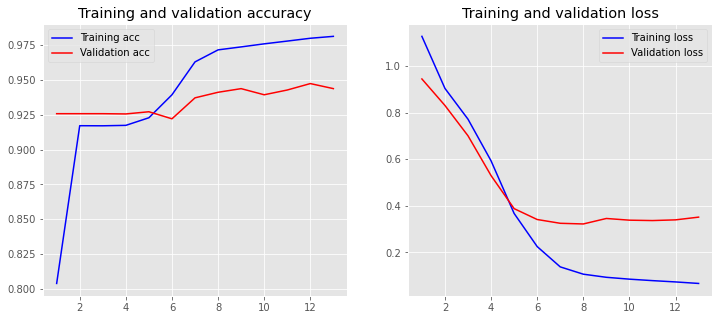

1000/1000 [==============================] - 20s 20ms/step
F1-score: 46.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.4661629279811098,0.48630406936644005,0.4760205434861235,20298.0
Disease,0.5425834843385969,0.3683871345714453,0.43883034405750576,17069.0
micro avg,0.4931937492369674,0.4324403885781572,0.46082331636508816,37367.0
macro avg,0.5043732061598534,0.42734560196894267,0.4574254437718146,37367.0
weighted avg,0.5010713358400749,0.4324403885781572,0.45903230482508367,37367.0



In [23]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_21 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_21 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 1000 samples
Epoch 1/100
750/750 [==============================] - 49s 65ms/ste

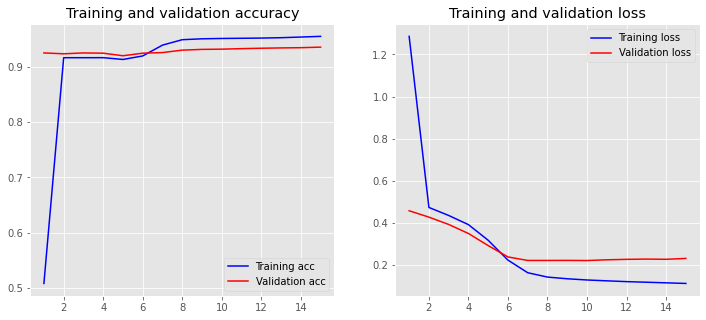

1000/1000 [==============================] - 20s 20ms/step
F1-score: 29.9%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.3312337662337662,0.5026110946891319,0.3993111276370895,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.3312337662337662,0.273021650119089,0.2993237196884122,37367.0
macro avg,0.1656168831168831,0.25130554734456595,0.19965556381854474,37367.0
weighted avg,0.17992835889991132,0.273021650119089,0.2169084290624787,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_22 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_22 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 1000 samples
Epoch 1/100
750/750 [==============================] - 51s 68ms/ste

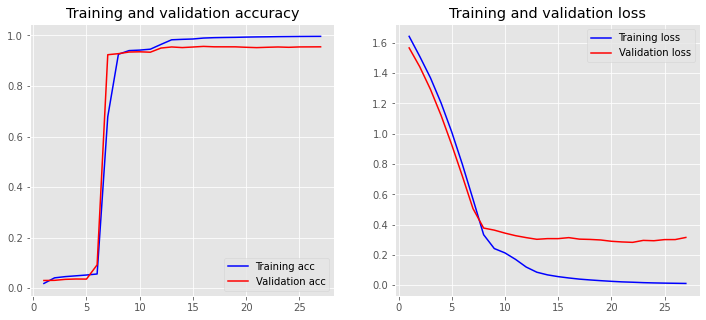

1000/1000 [==============================] - 20s 20ms/step
F1-score: 57.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.894203413940256,0.495516799684698,0.6376719710898371,20298.0
Disease,0.49572319408421167,0.5262757044935262,0.5105427678317703,17069.0
micro avg,0.6483366815349518,0.5095672652340301,0.5706365380004794,37367.0
macro avg,0.6949633040122338,0.510896252089112,0.5741073694608037,37367.0
weighted avg,0.7121802685787654,0.5095672652340301,0.5796001866165869,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_23 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_23 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 1000 samples
Epoch 1/100
750/750 [==============================] - 51s 68ms/ste

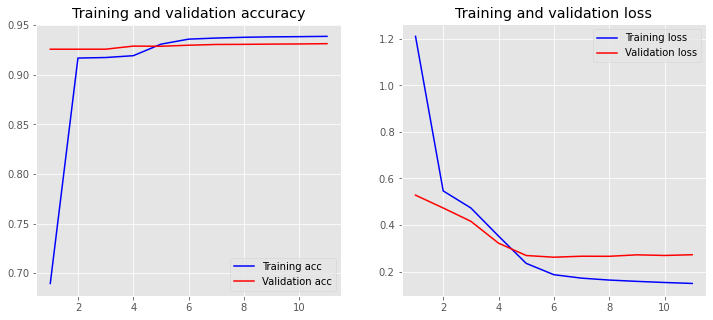

1000/1000 [==============================] - 20s 20ms/step
F1-score: 21.1%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.258575711560176,0.38906790087292753,0.3106755239520958,17069.0
micro avg,0.258575711560176,0.17772365991382771,0.21065820777160985,37367.0
macro avg,0.129287855780088,0.19453395043646377,0.1553377619760479,37367.0
weighted avg,0.11811568551450864,0.17772365991382771,0.14191453738160204,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_24 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_24 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 1000 samples
Epoch 1/100
750/750 [==============================] - 50s 67ms/ste

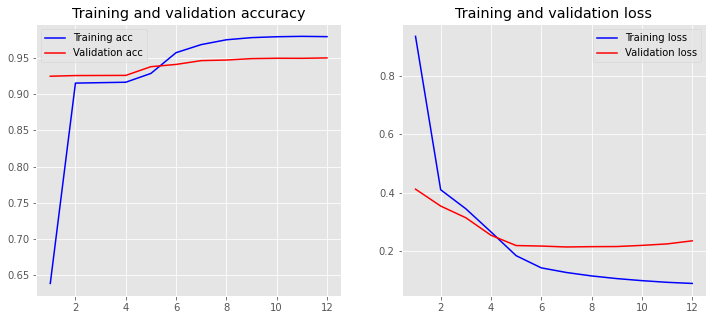

1000/1000 [==============================] - 20s 20ms/step
F1-score: 47.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7803158967391305,0.45270469997044044,0.5729874664837563,20298.0
Disease,0.387577711259498,0.39445778897416367,0.39098748584535875,17069.0
micro avg,0.5462467407712365,0.42609789386356944,0.4787491543260919,37367.0
macro avg,0.5839468039993143,0.42358124447230205,0.4819874761645575,37367.0
weighted avg,0.6009156749404352,0.42609789386356944,0.4898510715492739,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_25 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_25 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 1000 samples
Epoch 1/100
750/750 [==============================] - 51s 69ms/ste

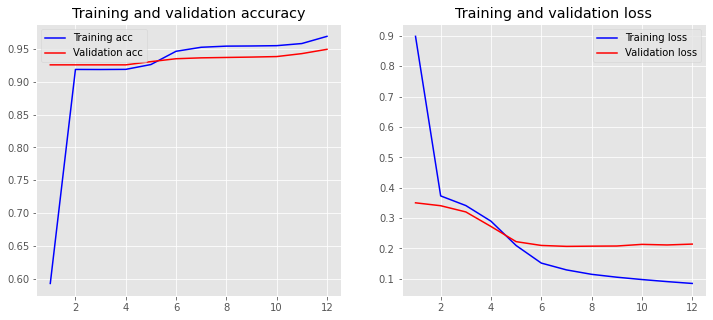

1000/1000 [==============================] - 20s 20ms/step
F1-score: 32.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.3809664767261156,0.5072420928170263,0.43512805341898403,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.3809664767261156,0.27553723874006475,0.31978631217678943,37367.0
macro avg,0.1904832383630578,0.25362104640851313,0.21756402670949201,37367.0
weighted avg,0.20694349411477225,0.2755372387400647,0.23636441855911736,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_26 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_26 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 1000 samples
Epoch 1/100
750/750 [==============================] - 52s 69ms/ste

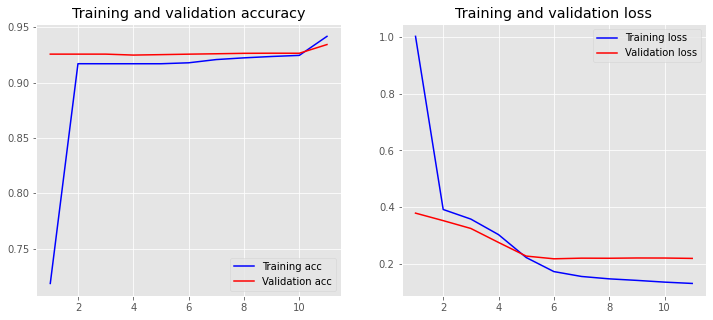

1000/1000 [==============================] - 21s 21ms/step
F1-score: 0.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.13123359580052493,0.0024632968765395604,0.004835823782581362,20298.0
Disease,0.05172413793103448,0.00017575722069248346,0.0003503240497460151,17069.0
micro avg,0.12072892938496584,0.0014183637969331228,0.0028037877585568426,37367.0
macro avg,0.0914788668657797,0.0013195270486160218,0.0025930739161636887,37367.0
weighted avg,0.0949141980331277,0.0014183637969331225,0.00278687698621648,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_27 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_27 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 1000 samples
Epoch 1/100
750/750 [==============================] - 52s 69ms/ste

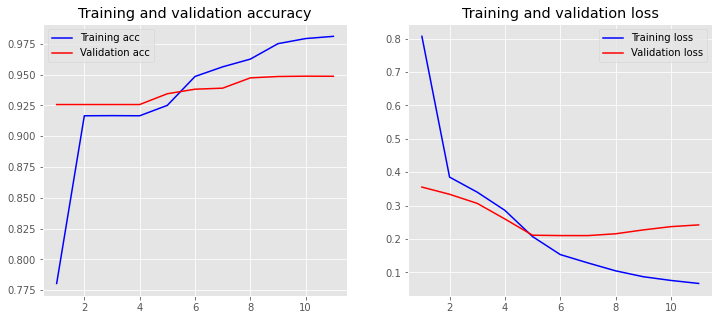

1000/1000 [==============================] - 21s 21ms/step
F1-score: 32.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.41832653226132277,0.5100995171938122,0.4596772403382983,20298.0
Disease,0.06070713809206137,0.005331302361005331,0.00980180956484274,17069.0
micro avg,0.3979047619047619,0.27952471432012205,0.32837134728138706,37367.0
macro avg,0.23951683517669206,0.25771540977740875,0.23473952495157052,37367.0
weighted avg,0.25496834350988107,0.27952471432012205,0.2541771004321749,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_28 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_28 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 1000 samples
Epoch 1/100
750/750 [==============================] - 52s 69ms/ste

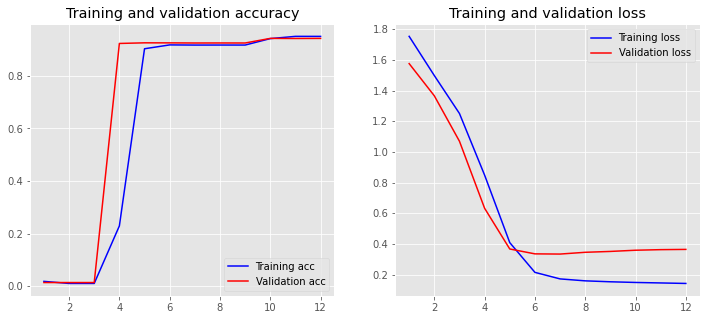

1000/1000 [==============================] - 21s 21ms/step
F1-score: 40.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8284576629286526,0.5022662331264164,0.6253833885412832,20298.0
Disease,0.0066555740432612314,0.00023434296092331126,0.00045274476513865305,17069.0
micro avg,0.7901913690245603,0.2729413653758664,0.4057365636313005,37367.0
macro avg,0.41755661848595693,0.25125028804366983,0.3129180666532109,37367.0
weighted avg,0.45306387013863086,0.2729413653758664,0.3399191779111815,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_29 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_29 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 1000 samples
Epoch 1/100
750/750 [==============================] - 52s 70ms/ste

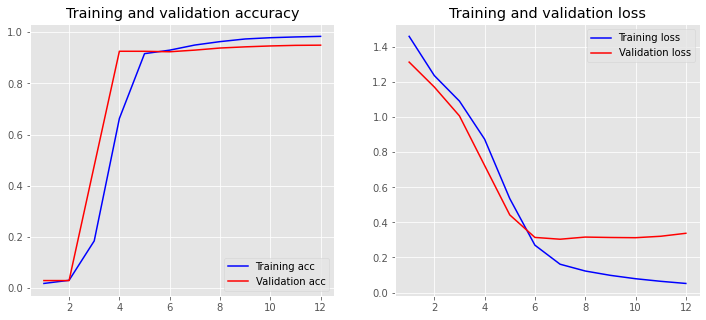

1000/1000 [==============================] - 21s 21ms/step
F1-score: 32.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.41999344208541683,0.5048280618780175,0.4585197780562019,20298.0
Disease,0.09213147410358566,0.010838361942703146,0.0193950830843424,17069.0
micro avg,0.3950617283950617,0.27917681376615733,0.32716039703322725,37367.0
macro avg,0.25606245809450123,0.25783321191036035,0.23895743057027216,37367.0
weighted avg,0.27022825003141526,0.27917681376615733,0.2579305036034851,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_30 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_30 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 750 samples, validate on 1000 samples
Epoch 1/100
750/750 [==============================] - 52s 70ms/ste

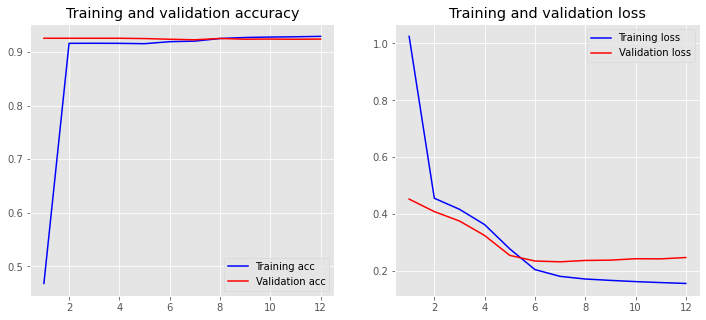

1000/1000 [==============================] - 21s 21ms/step
F1-score: 2.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.04896787210926587,0.031086806581929253,0.03803037608486017,20298.0
Disease,0.10457516339869281,0.000937371843693245,0.001858088491464406,17069.0
micro avg,0.04962036966025002,0.01731474295501378,0.025671547038051024,37367.0
macro avg,0.07677151775397933,0.016012089212811248,0.01994423228816229,37367.0
weighted avg,0.07436891728332931,0.01731474295501378,0.021507112859777286,37367.0



In [24]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_31 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_31 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 875 samples, validate on 1000 samples
Epoch 1/100
875/875 [==============================] - 49s 56ms/ste

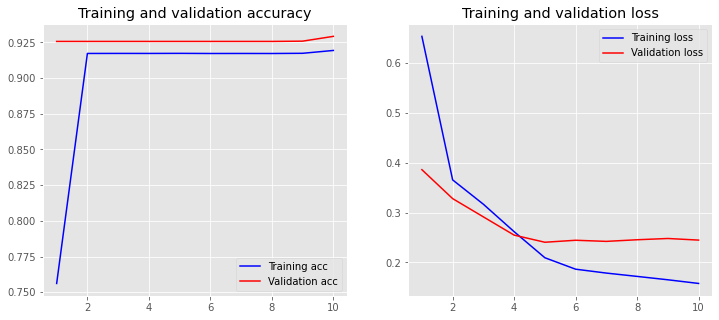

1000/1000 [==============================] - 22s 22ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_32 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_32 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 875 samples, validate on 1000 samples
Epoch 1/100
875/875 [==============================] - 49s 56ms/ste

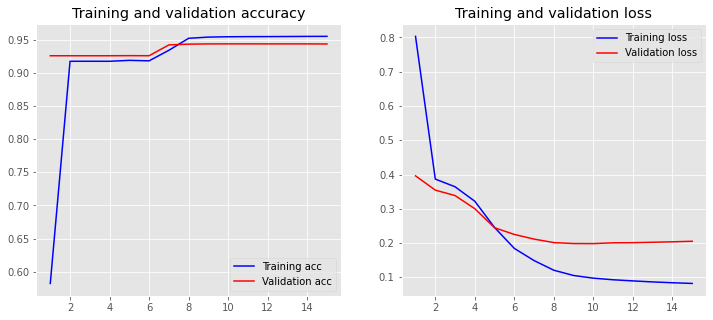

1000/1000 [==============================] - 22s 22ms/step
F1-score: 42.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9001474798299645,0.5111833678194896,0.6520659858601728,20298.0
Disease,0.4745762711864407,0.0065616029058527155,0.012944235770008668,17069.0
micro avg,0.8916092833460851,0.2806754623063131,0.4269489110523102,37367.0
macro avg,0.6873618755082026,0.25887248536267116,0.33250511081509077,37367.0
weighted avg,0.7057493488497866,0.2806754623063131,0.3601193711389212,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_33 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_33 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 875 samples, validate on 1000 samples
Epoch 1/100
875/875 [==============================] - 49s 56ms/ste

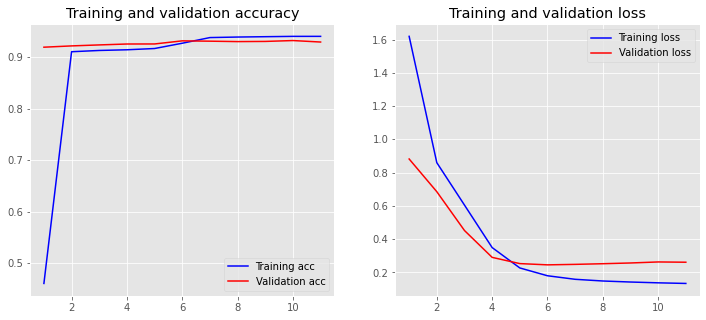

1000/1000 [==============================] - 22s 22ms/step
F1-score: 22.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.324582338902148,0.006700167504187605,0.013129314089877879,20298.0
Disease,0.28921994440583737,0.3901224441970824,0.33217768687800864,17069.0
micro avg,0.2898519814016977,0.18184494339925603,0.22348297977306367,37367.0
macro avg,0.3069011416539927,0.19841130585063502,0.17265350048394326,37367.0
weighted avg,0.30842902952067436,0.18184494339925603,0.15886851378802339,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_34 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_34 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 875 samples, validate on 1000 samples
Epoch 1/100
875/875 [==============================] - 49s 56ms/ste

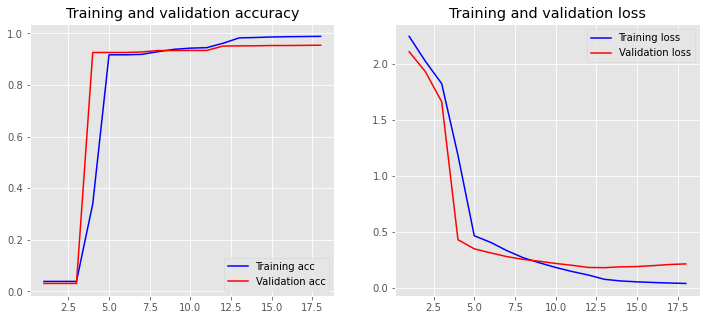

1000/1000 [==============================] - 22s 22ms/step
F1-score: 58.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8463823978157874,0.5192629815745393,0.6436444688711794,20298.0
Disease,0.5324563028843184,0.5050676665299666,0.5184004810583283,17069.0
micro avg,0.6689359028068705,0.5127786549629352,0.580539607035191,37367.0
macro avg,0.689419350350053,0.512165324052253,0.5810224749647539,37367.0
weighted avg,0.7029830209756545,0.5127786549629352,0.5864338384224531,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_35 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_35 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_35 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 875 samples, validate on 1000 samples
Epoch 1/100
875/875 [==============================] - 50s 57ms/ste

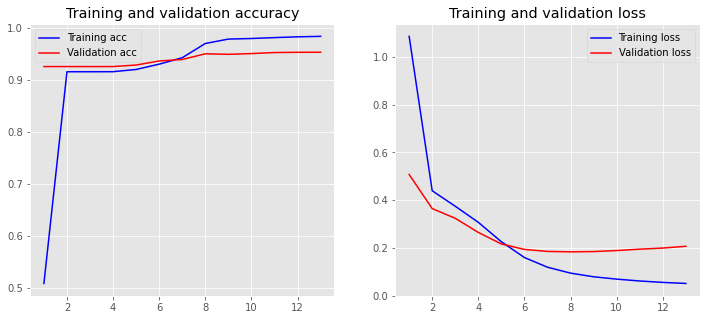

1000/1000 [==============================] - 23s 23ms/step
F1-score: 49.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.89125,0.4917725884323579,0.6338180201917583,20298.0
Disease,0.3481088894242351,0.423281973167731,0.3820325719120135,17069.0
micro avg,0.5384759818494759,0.46048652554392916,0.49643691757306485,37367.0
macro avg,0.6196794447121176,0.45752728080004446,0.5079252960518859,37367.0
weighted avg,0.6431467105623215,0.46048652554392916,0.5188040823137653,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_36 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_36 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_36 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 875 samples, validate on 1000 samples
Epoch 1/100
875/875 [==============================] - 50s 57ms/ste

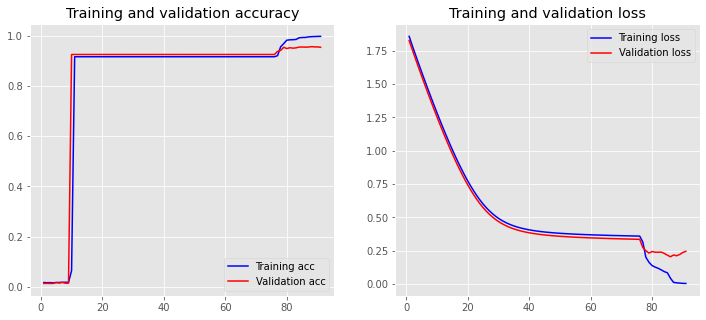

1000/1000 [==============================] - 22s 22ms/step
F1-score: 60.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9059873494497878,0.5151246428219529,0.656804547881529,20298.0
Disease,0.5235076597992604,0.5805846856875037,0.5505708491902552,17069.0
micro avg,0.6683732073118703,0.5450263601573581,0.6004304372180783,37367.0
macro avg,0.7147475046245241,0.5478546642547283,0.6036876985358921,37367.0
weighted avg,0.7312731411203833,0.5450263601573581,0.6082776925556707,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_37 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_37 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_37 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 875 samples, validate on 1000 samples
Epoch 1/100
875/875 [==============================] - 48s 54ms/ste

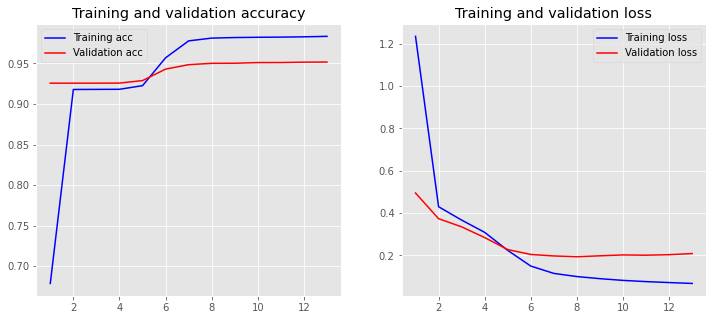

1000/1000 [==============================] - 22s 22ms/step
F1-score: 53.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7553672722050693,0.5182776628239235,0.6147552958363768,20298.0
Disease,0.46629537161513346,0.4267385318413498,0.4456408687672071,17069.0
micro avg,0.6025450115067009,0.4764631894452324,0.5321377867443772,37367.0
macro avg,0.6108313219101014,0.47250809733263666,0.530198082301792,37367.0
weighted avg,0.6233211279823697,0.4764631894452324,0.5375049370801572,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_38 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_38 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_38 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 875 samples, validate on 1000 samples
Epoch 1/100
875/875 [==============================] - 48s 55ms/ste

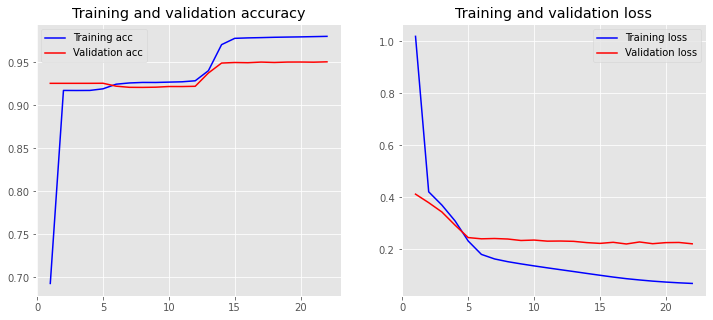

1000/1000 [==============================] - 22s 22ms/step
F1-score: 51.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6668368323655159,0.5148290471967681,0.5810559092551919,20298.0
Disease,0.5212184536248191,0.3799285253969184,0.4394971366609061,17069.0
micro avg,0.6023903532173728,0.45320737549174406,0.5172571777642029,37367.0
macro avg,0.5940276429951675,0.44737878629684324,0.510276522958049,37367.0
weighted avg,0.6003193140545744,0.45320737549174406,0.5163927923495837,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_39 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_39 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_39 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 875 samples, validate on 1000 samples
Epoch 1/100
875/875 [==============================] - 48s 55ms/ste

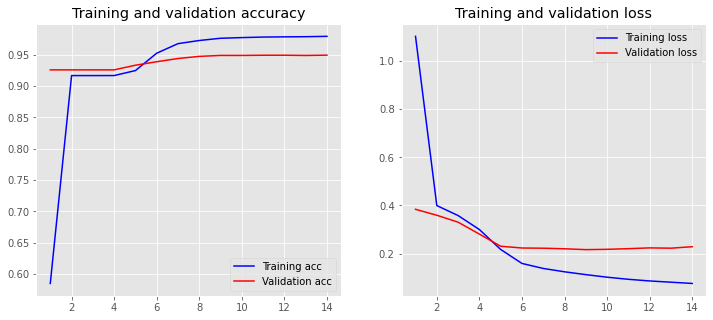

1000/1000 [==============================] - 23s 23ms/step
F1-score: 50.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6238152369526094,0.5123164843826978,0.562594676476953,20298.0
Disease,0.46722492964513695,0.3987931337512449,0.4303053290347051,17069.0
micro avg,0.5507858766285733,0.46045976396285493,0.5015887823222459,37367.0
macro avg,0.5455200832988731,0.4555548090669714,0.49645000275582907,37367.0
weighted avg,0.5522858137869486,0.46045976396285493,0.5021657720561612,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_40 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_40 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_40 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 875 samples, validate on 1000 samples
Epoch 1/100
875/875 [==============================] - 49s 56ms/ste

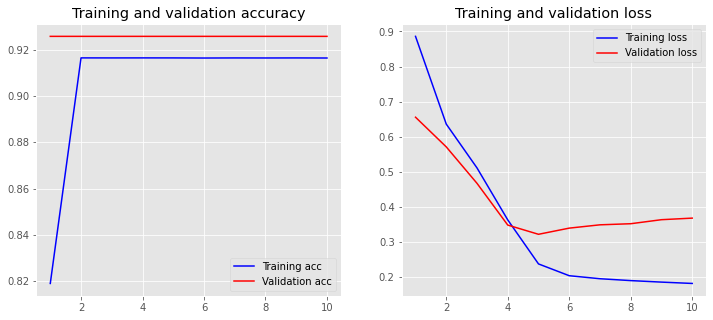

1000/1000 [==============================] - 23s 23ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0



In [25]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_41 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_41 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_41 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 46s 46ms/

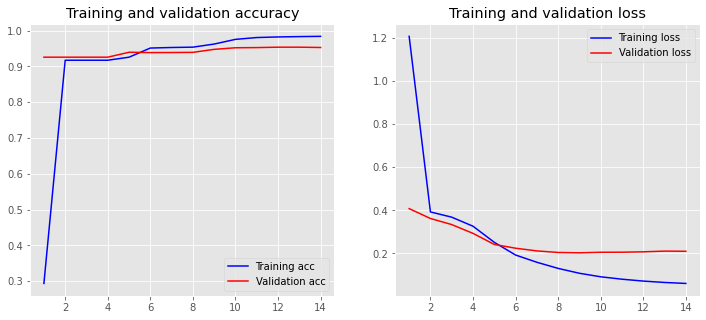

1000/1000 [==============================] - 23s 23ms/step
F1-score: 45.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5828597152664453,0.5102965809439354,0.5441697969476478,20298.0
Disease,0.5594074074074074,0.22121975511160583,0.3170578109912255,17069.0
micro avg,0.5764038986990743,0.3782481869028822,0.4567605997931748,37367.0
macro avg,0.5711335613369264,0.3657581680277706,0.4306138039694366,37367.0
weighted avg,0.5721468551801145,0.3782481869028822,0.4404265344890568,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_42 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_42 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_42 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 47s 47ms/

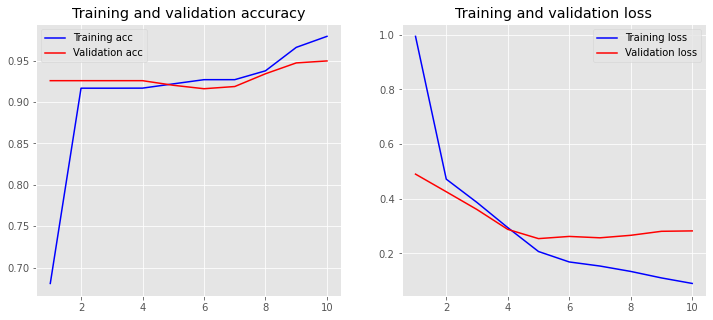

1000/1000 [==============================] - 23s 23ms/step
F1-score: 29.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3850837930675549,0.36451867179032416,0.37451913342781934,20298.0
Disease,0.2998681484271991,0.09326849844747788,0.1422825989811422,17069.0
micro avg,0.3666354034987563,0.2406133754382209,0.2905477460009695,37367.0
macro avg,0.342475970747377,0.228893585118901,0.2584008662044808,37367.0
weighted avg,0.3461578466879624,0.2406133754382209,0.2684350109007143,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_43 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_43 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_43 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 47s 47ms/

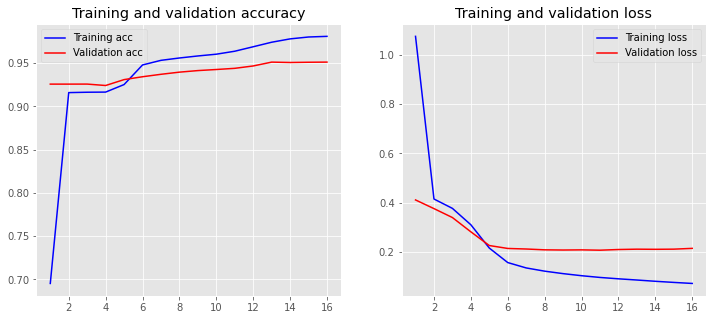

1000/1000 [==============================] - 23s 23ms/step
F1-score: 46.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7847311019180143,0.5139915262587447,0.6211413092013217,20298.0
Disease,0.4118174826967444,0.18823598336164976,0.25837320574162675,17069.0
micro avg,0.6468218230080106,0.3651885353386678,0.46681718664477284,37367.0
macro avg,0.5982742923073794,0.35111375481019724,0.4397572574714742,37367.0
weighted avg,0.6143866116863164,0.3651885353386678,0.4554312238866448,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_44 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_44 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_44 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_44 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 47s 47ms/

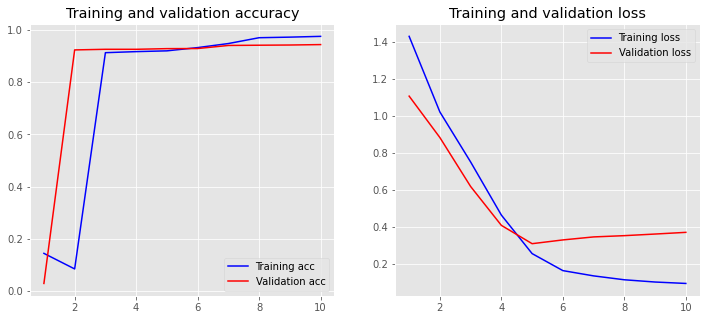

1000/1000 [==============================] - 23s 23ms/step
F1-score: 11.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.25,4.926593753079121e-05,9.851246182642104e-05,20298.0
Disease,0.1505888580124388,0.20001171714804616,0.17181680926019124,17069.0
micro avg,0.150606394707828,0.09139079936842669,0.11375370573931581,37367.0
macro avg,0.2002944290062194,0.10003049154278848,0.08595766086100884,37367.0
weighted avg,0.20458964373415894,0.09139079936842669,0.07853830179603279,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_45 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_45 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_45 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 48s 48ms/

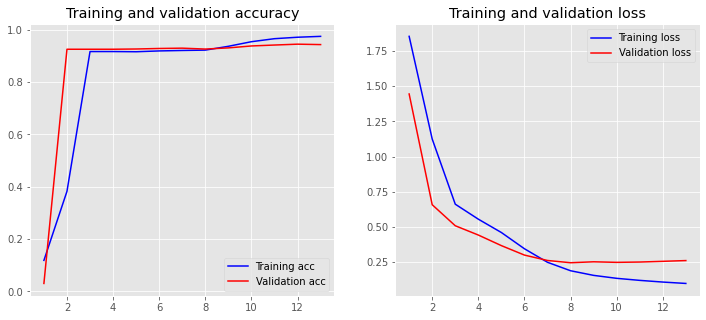

1000/1000 [==============================] - 24s 24ms/step
F1-score: 18.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.11108746541817408,0.025716819391073013,0.04176501180141617,20298.0
Disease,0.3519600966409477,0.2645732028824184,0.3020735785953177,17069.0
micro avg,0.2873930405019966,0.1348248454518693,0.183543727343935,37367.0
macro avg,0.2315237810295609,0.14514501113674572,0.17191929519836693,37367.0
weighted avg,0.22111650019060758,0.1348248454518693,0.16067225419724954,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_46 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_46 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_46 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 47s 47ms/

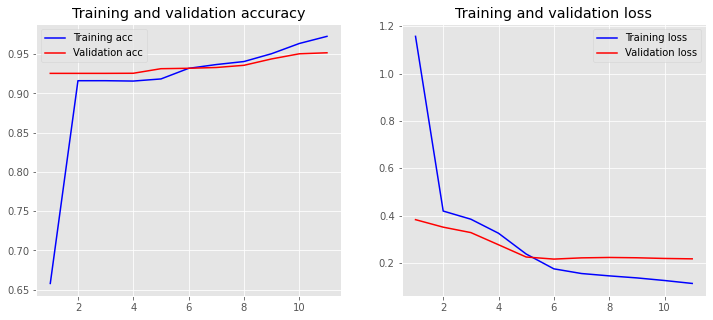

1000/1000 [==============================] - 24s 24ms/step
F1-score: 24.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.24324324324324326,0.0004433934377771209,0.0008851733464470125,20298.0
Disease,0.3331644870141831,0.42386783057003924,0.37308237720768334,17069.0
micro avg,0.33301153863834876,0.19386089330157627,0.24506089309878215,37367.0
macro avg,0.2882038651287132,0.21215561200390817,0.18698377527706517,37367.0
weighted avg,0.28431867637745717,0.19386089330157627,0.17090240975042492,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_47 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_47 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_47 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_47 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 48s 48ms/

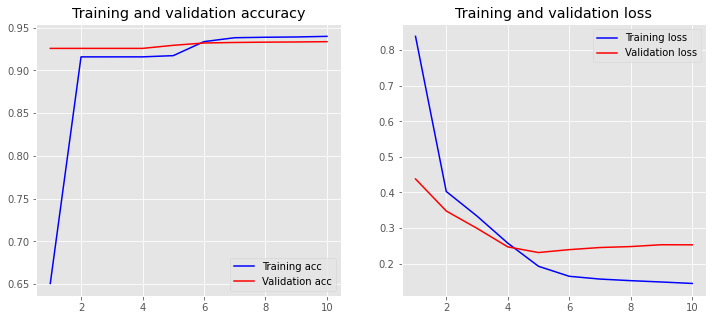

1000/1000 [==============================] - 24s 24ms/step
F1-score: 6.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.011152416356877323,0.00014779781259237365,0.00029172946953858126,20298.0
Disease,0.17589928057553958,0.08594528091862441,0.11547089613916328,17069.0
micro avg,0.17075153908700197,0.0393395241790885,0.06394640682095006,37367.0
macro avg,0.09352584846620846,0.04304653936560839,0.05788131280435093,37367.0
weighted avg,0.08640770110942224,0.0393395241790885,0.05290481577252849,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_48 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_48 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_48 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_48 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 48s 48ms/

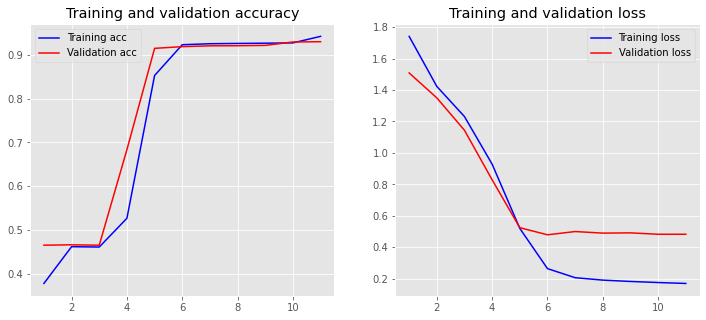

1000/1000 [==============================] - 24s 24ms/step
F1-score: 37.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.39410164881862997,0.22844615233027885,0.28923403193612773,20298.0
Disease,0.40041437708314565,0.5208272306520593,0.4527513941585394,17069.0
micro avg,0.39822774375883185,0.36200390719083686,0.3792528211957665,37367.0
macro avg,0.3972580129508878,0.37463669149116907,0.37099271304733356,37367.0
weighted avg,0.3969852615985432,0.36200390719083686,0.36392768825786465,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_49 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_49 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_49 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 48s 48ms/

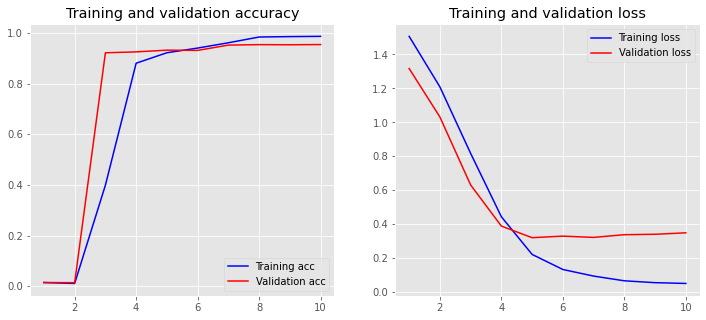

1000/1000 [==============================] - 24s 24ms/step
F1-score: 15.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.2219564459062142,0.2609408869881071,0.2398750538560965,17069.0
micro avg,0.22142679592344022,0.11919608210453074,0.15497025155700914,37367.0
macro avg,0.1109782229531071,0.13047044349405354,0.11993752692804825,37367.0
weighted avg,0.10138824564918698,0.11919608210453074,0.10957334798805661,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_50 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_50 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_50 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_50 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 49s 49ms/

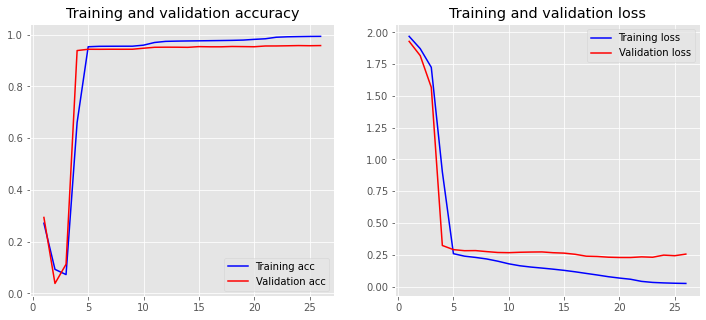

1000/1000 [==============================] - 25s 25ms/step
F1-score: 57.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8332148779909974,0.519804906887378,0.6402111586420314,20298.0
Disease,0.5451296982530439,0.48262932802155956,0.5119791181131724,17069.0
micro avg,0.6764716471647164,0.5028233468033292,0.5768628534585981,37367.0
macro avg,0.6891722881220206,0.5012171174544688,0.5760951383776018,37367.0
weighted avg,0.7016194613681181,0.5028233468033292,0.5816356053520404,37367.0



In [26]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_51 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_51 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_51 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_51 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 3000 samples, validate on 1000 samples
Epoch 1/100
3000/3000 [==============================] - 39s 13ms/

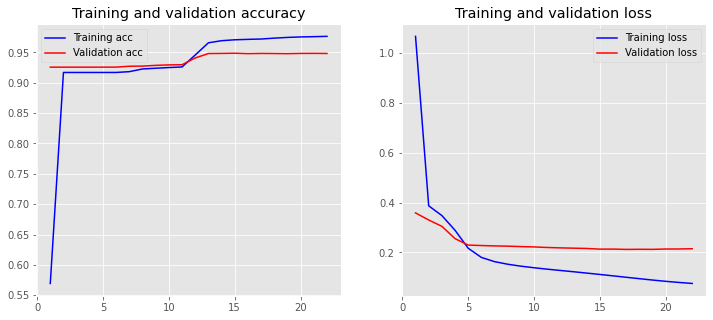

1000/1000 [==============================] - 25s 25ms/step
F1-score: 53.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6420668926264629,0.49463001280914376,0.5587866982050925,20298.0
Disease,0.562108828510419,0.4472435409221395,0.4981402936378466,17069.0
micro avg,0.6049010883701827,0.47298418390558516,0.5308703161372681,37367.0
macro avg,0.602087860568441,0.4709367768656416,0.5284634959214696,37367.0
weighted avg,0.6055425744741693,0.47298418390558516,0.5310838192060207,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_52 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_52 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_52 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_52 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 3000 samples, validate on 1000 samples
Epoch 1/100
3000/3000 [==============================] - 39s 13ms/

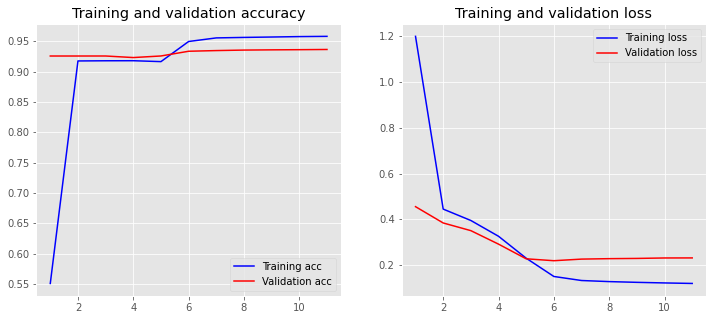

1000/1000 [==============================] - 25s 25ms/step
F1-score: 31.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3664796932689577,0.5085722731303577,0.42598935336111915,20298.0
Disease,0.08445945945945946,0.005858574023082781,0.01095710294198214,17069.0
micro avg,0.3551035704551649,0.2789359595364894,0.31244473088625424,37367.0
macro avg,0.22546957636420856,0.2572154235767202,0.21847322815155065,37367.0
weighted avg,0.23765470408346448,0.2789359595364894,0.23640534922901732,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_53 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_53 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_53 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_53 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 3000 samples, validate on 1000 samples
Epoch 1/100
3000/3000 [==============================] - 39s 13ms/

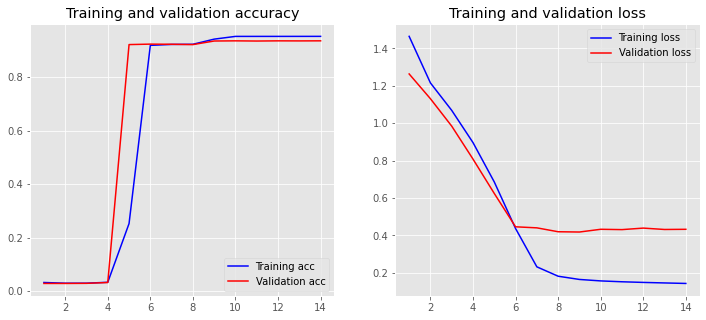

1000/1000 [==============================] - 25s 25ms/step
F1-score: 36.1%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.5108210237031948,0.5128091437580057,0.5118131530424094,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.5108210237031948,0.27856129740145047,0.36052230534774177,37367.0
macro avg,0.2554105118515974,0.25640457187900284,0.2559065765212047,37367.0
weighted avg,0.2774813375204712,0.27856129740145047,0.27802026869844587,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_54 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_54 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_54 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_54 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 3000 samples, validate on 1000 samples
Epoch 1/100
3000/3000 [==============================] - 40s 13ms/

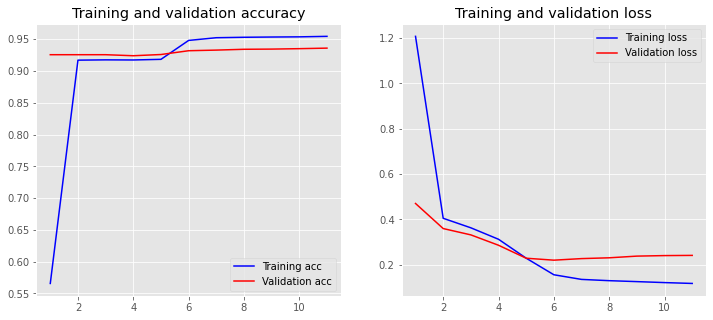

1000/1000 [==============================] - 26s 26ms/step
F1-score: 30.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3370716917158413,0.5093605281308503,0.40568166212159856,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.33684107643187594,0.2766879867262558,0.30381569474442044,37367.0
macro avg,0.16853584585792064,0.25468026406542515,0.20284083106079928,37367.0
weighted avg,0.1830995583923822,0.2766879867262558,0.2203689452657213,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_55 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_55 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_55 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_55 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 3000 samples, validate on 1000 samples
Epoch 1/100
3000/3000 [==============================] - 40s 13ms/

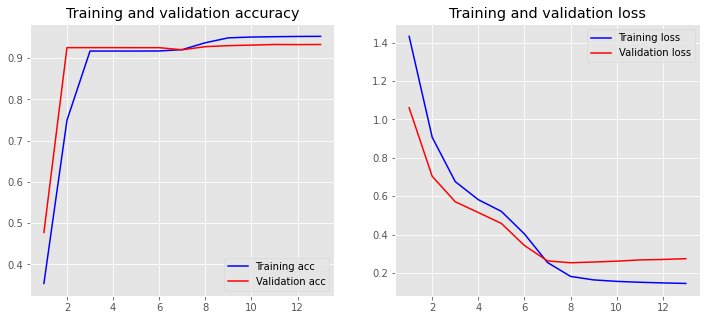

1000/1000 [==============================] - 26s 26ms/step
F1-score: 29.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.394012474012474,0.4668440240417775,0.42734734373590694,20298.0
Disease,0.07585974376264329,0.026363583103872518,0.03912873353332464,17069.0
micro avg,0.3310653058501768,0.2656354537426071,0.2947630996748281,37367.0
macro avg,0.23493610888755867,0.24660380357282502,0.23323803863461579,37367.0
weighted avg,0.24868239793908412,0.2656354537426071,0.25001163421820743,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_56 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_56 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_56 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_56 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 3000 samples, validate on 1000 samples
Epoch 1/100
3000/3000 [==============================] - 40s 13ms/

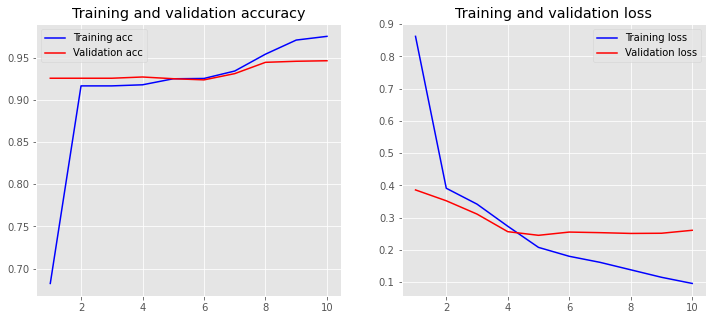

1000/1000 [==============================] - 26s 26ms/step
F1-score: 23.1%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.34851015679724123,0.37893256781299434,0.3630852138767262,17069.0
micro avg,0.34851015679724123,0.1730939063879894,0.23130565389979615,37367.0
macro avg,0.17425507839862062,0.18946628390649717,0.1815426069383631,37367.0
weighted avg,0.1591971489916801,0.1730939063879894,0.16585493926892284,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_57 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_57 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_57 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_57 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 3000 samples, validate on 1000 samples
Epoch 1/100
3000/3000 [==============================] - 40s 13ms/

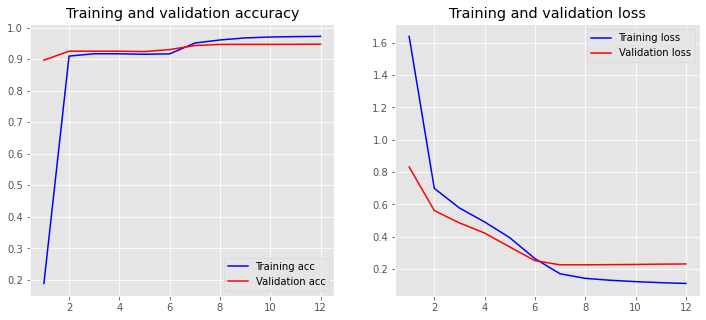

1000/1000 [==============================] - 26s 26ms/step
F1-score: 37.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5492146312299582,0.4978322987486452,0.5222627077034396,20298.0
Disease,0.22328525169267,0.0888745679301658,0.1271424380840632,17069.0
micro avg,0.4613186202516572,0.31102309524446703,0.37154731457800505,37367.0
macro avg,0.3862499414613141,0.2933534333394055,0.32470257289375143,37367.0
weighted avg,0.4003322328752074,0.31102309524446703,0.3417743655263011,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_58 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_58 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_58 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_58 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 3000 samples, validate on 1000 samples
Epoch 1/100
3000/3000 [==============================] - 40s 13ms/

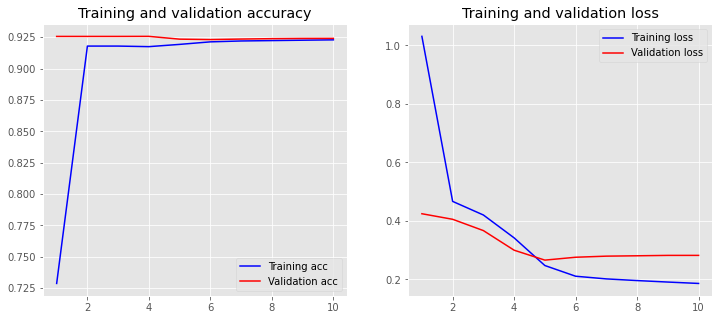

1000/1000 [==============================] - 26s 26ms/step
F1-score: 9.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.13636363636363635,0.15976331360946747,0.14713896457765666,17069.0
micro avg,0.1363295505674149,0.0729788315893703,0.09506710824472721,37367.0
macro avg,0.06818181818181818,0.07988165680473373,0.07356948228882833,37367.0
weighted avg,0.0622900128212302,0.0729788315893703,0.06721211192699499,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_59 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_59 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_59 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_59 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 3000 samples, validate on 1000 samples
Epoch 1/100
3000/3000 [==============================] - 41s 14ms/

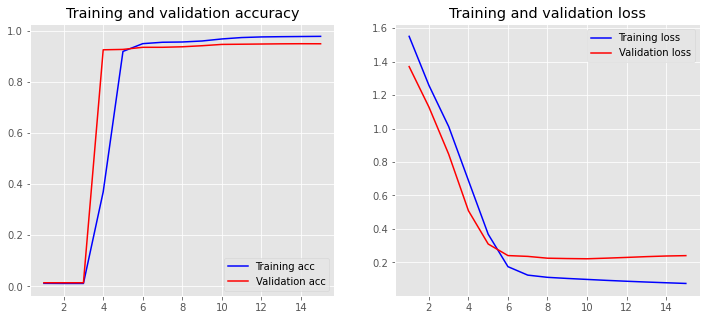

1000/1000 [==============================] - 27s 27ms/step
F1-score: 46.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7299392875429742,0.4916247906197655,0.5875356943095176,20298.0
Disease,0.40718774895990084,0.26949440506180794,0.32433194669674964,17069.0
micro avg,0.5839074014738865,0.39015709048090563,0.46776289404026633,37367.0
macro avg,0.5685635182514375,0.38055959784078675,0.4559338205031336,37367.0
weighted avg,0.5825085060492904,0.39015709048090563,0.4673059523446198,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_60 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_60 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_60 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_60 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 3000 samples, validate on 1000 samples
Epoch 1/100
3000/3000 [==============================] - 40s 13ms/

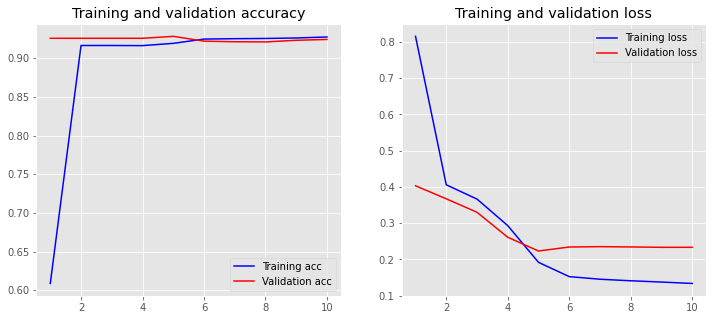

1000/1000 [==============================] - 27s 27ms/step
F1-score: 3.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.09028831562974203,0.017587939698492462,0.029440870856011873,20298.0
Disease,0.09556993529118965,0.022496924248637883,0.03642054346279698,17069.0
micro avg,0.09295032614149523,0.01983033157598951,0.0326870905842652,37367.0
macro avg,0.09292912546046583,0.020042431973565172,0.032930707159404424,37367.0
weighted avg,0.09270092477688388,0.01983033157598951,0.03262913942788585,37367.0



In [27]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 1000% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 5500
Points in y_train after augmentation: 5500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_61 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_61 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_61 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_61 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 5500 samples, validate on 1000 samples
Epoch 1/100
5500/5500 [==============================] - 38s 7ms/s

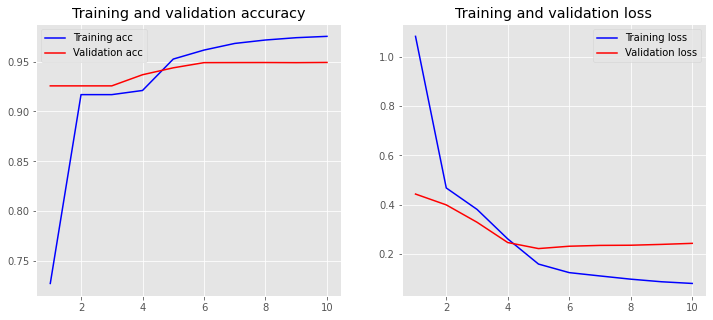

1000/1000 [==============================] - 27s 27ms/step
F1-score: 42.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.646458958958959,0.5090649325056655,0.5695937379416791,20298.0
Disease,0.41981659583985687,0.10996543441326381,0.174280408542247,17069.0
micro avg,0.5969200684429234,0.32675890491610243,0.42233060080938056,37367.0
macro avg,0.5331377773994079,0.30951518345946466,0.37193707324196307,37367.0
weighted avg,0.5429302171257919,0.3267589049161024,0.3890172073259244,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 5500
Points in y_train after augmentation: 5500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_62 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_62 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_62 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_62 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 5500 samples, validate on 1000 samples
Epoch 1/100
5500/5500 [==============================] - 39s 7ms/s

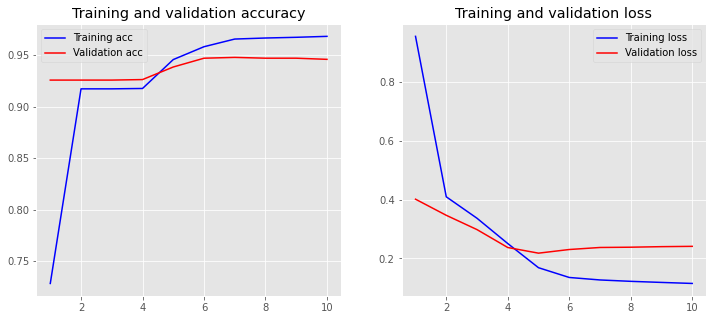

1000/1000 [==============================] - 28s 28ms/step
F1-score: 35.5%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.4892604804521903,0.5117252931323283,0.5002408013870159,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.4892604804521903,0.27797254261781784,0.35452326910934007,37367.0
macro avg,0.24463024022609514,0.25586264656616414,0.25012040069350794,37367.0
weighted avg,0.26576950871674365,0.27797254261781784,0.2717340912182848,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 5500
Points in y_train after augmentation: 5500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_63 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_63 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_63 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_63 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 5500 samples, validate on 1000 samples
Epoch 1/100
5500/5500 [==============================] - 40s 7ms/s

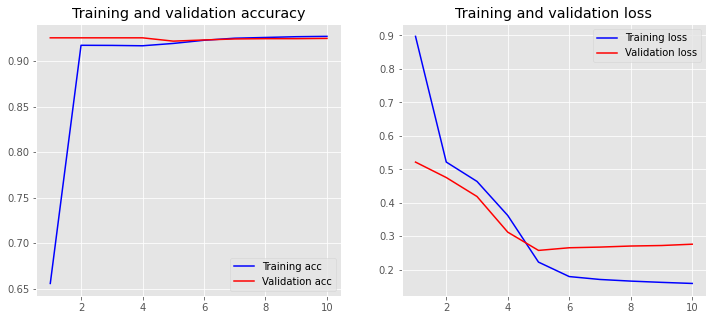

1000/1000 [==============================] - 27s 27ms/step
F1-score: 11.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.03987863025574339,0.013597398758498374,0.020279951504463795,20298.0
Disease,0.22950028164480565,0.16708653113832092,0.19338215351234064,17069.0
micro avg,0.1616704568947695,0.08371022560012846,0.11030591554262541,37367.0
macro avg,0.1346894559502745,0.09034196494840965,0.10683105250840222,37367.0
weighted avg,0.12649655429459863,0.08371022560012846,0.09935189964245854,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 5500
Points in y_train after augmentation: 5500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_64 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_64 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_64 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_64 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 5500 samples, validate on 1000 samples
Epoch 1/100
5500/5500 [==============================] - 39s 7ms/s

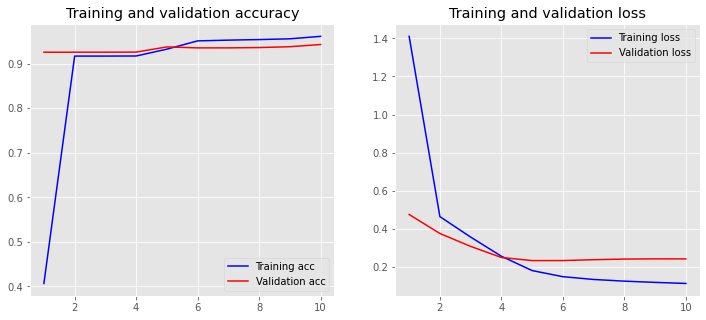

1000/1000 [==============================] - 28s 28ms/step
F1-score: 31.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3930377513818652,0.4939402896837127,0.437749688912175,20298.0
Disease,0.11242603550295859,0.0011131290643857285,0.0022044320686854624,17069.0
micro avg,0.3911909027182802,0.2688200818904381,0.3186612736933936,37367.0
macro avg,0.25273189344241187,0.2475267093740492,0.21997706049043023,37367.0
weighted avg,0.26485616392937883,0.2688200818904381,0.23879547827012387,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 5500
Points in y_train after augmentation: 5500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_65 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_65 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_65 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_65 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 5500 samples, validate on 1000 samples
Epoch 1/100
5500/5500 [==============================] - 39s 7ms/s

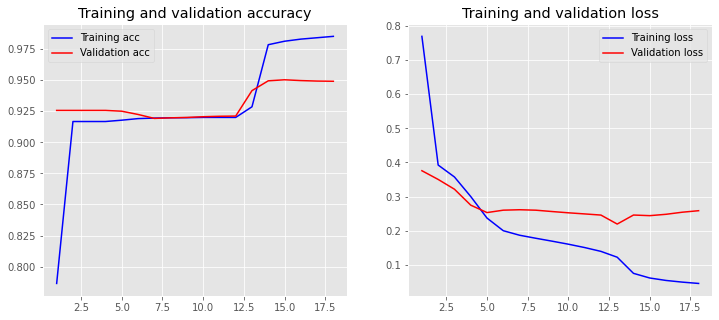

1000/1000 [==============================] - 28s 28ms/step
F1-score: 46.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.72022736725357,0.5118730909449207,0.5984333602119571,20298.0
Disease,0.3007859454461396,0.38115882594176576,0.33623607845163955,17069.0
micro avg,0.4686043931661859,0.45216367382984984,0.4602372553559511,37367.0
macro avg,0.5105066563498548,0.44651595844334324,0.4673347193317984,37367.0
weighted avg,0.528629282611211,0.45216367382984984,0.47866336523331665,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 5500
Points in y_train after augmentation: 5500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_66 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_66 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_66 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_66 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 5500 samples, validate on 1000 samples
Epoch 1/100
5500/5500 [==============================] - 39s 7ms/s

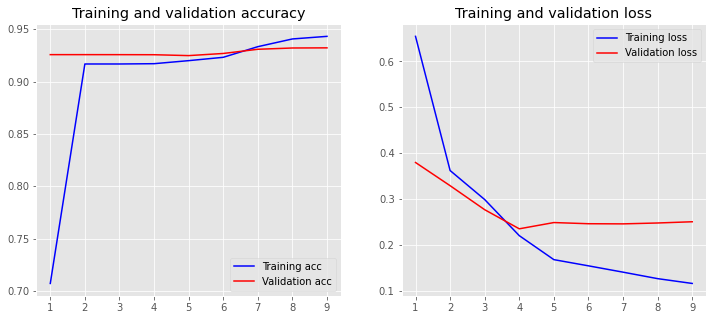

1000/1000 [==============================] - 28s 28ms/step
F1-score: 0.2%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.08661417322834646,0.002577772570156424,0.005006542640951244,17069.0
micro avg,0.08661417322834646,0.0011775095672652341,0.0023234323432343236,37367.0
macro avg,0.04330708661417323,0.001288886285078212,0.002503271320475622,37367.0
weighted avg,0.03956478504655567,0.0011775095672652341,0.002286955772162517,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 5500
Points in y_train after augmentation: 5500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_67 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_67 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_67 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_67 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 5500 samples, validate on 1000 samples
Epoch 1/100
5500/5500 [==============================] - 39s 7ms/s

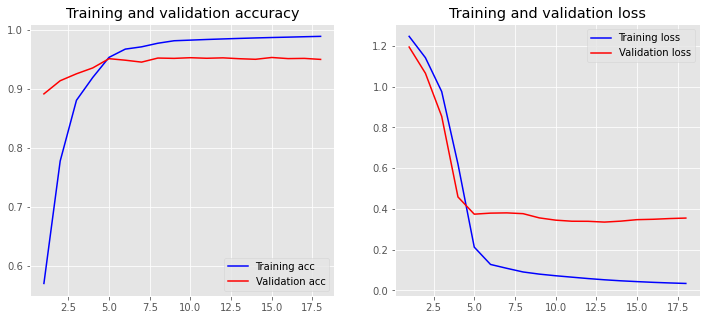

1000/1000 [==============================] - 28s 28ms/step
F1-score: 56.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9211168338303063,0.5022169671888856,0.650023912003826,20298.0
Disease,0.4720674836861372,0.521295916573906,0.49546188540564623,17069.0
micro avg,0.6381869233854793,0.5109321058688148,0.5675133391792875,37367.0
macro avg,0.6965921587582218,0.5117564418813958,0.5727428987047362,37367.0
weighted avg,0.7159940421261067,0.5109321058688148,0.5794209941350024,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 5500
Points in y_train after augmentation: 5500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_68 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_68 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_68 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_68 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 5500 samples, validate on 1000 samples
Epoch 1/100
5500/5500 [==============================] - 40s 7ms/s

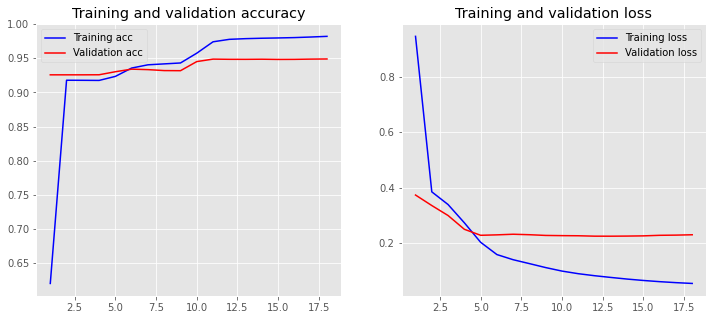

1000/1000 [==============================] - 28s 28ms/step
F1-score: 48.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7300931437775755,0.5135973987584984,0.6030019955461724,20298.0
Disease,0.34360313315926894,0.42404358779073176,0.3796087480988095,17069.0
micro avg,0.49974535989135355,0.47268980651376885,0.48584120697005956,37367.0
macro avg,0.5368481384684223,0.46882049327461506,0.49130537182249095,37367.0
weighted avg,0.553547047188503,0.47268980651376885,0.5009574283965741,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 5500
Points in y_train after augmentation: 5500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_69 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_69 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_69 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_69 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 5500 samples, validate on 1000 samples
Epoch 1/100
5500/5500 [==============================] - 40s 7ms/s

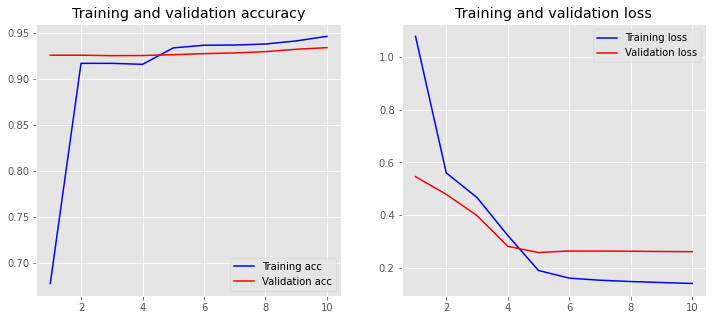

1000/1000 [==============================] - 28s 28ms/step
F1-score: 21.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.15134633240482823,0.0240910434525569,0.041565727400229506,20298.0
Disease,0.24279521414947114,0.4101587673560255,0.305027884280237,17069.0
micro avg,0.2335807397243186,0.20044424224583188,0.21574755519709646,37367.0
macro avg,0.19707077327714967,0.21712490540429122,0.17329680584023327,37367.0
weighted avg,0.19311958052480868,0.20044424224583188,0.16191350901997012,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 5500
Points in y_train after augmentation: 5500


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_70 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_70 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_70 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_70 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 5500 samples, validate on 1000 samples
Epoch 1/100
5500/5500 [==============================] - 40s 7ms/s

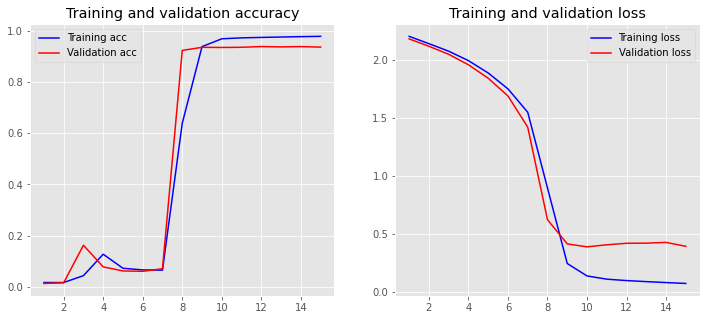

1000/1000 [==============================] - 29s 29ms/step
F1-score: 43.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.45069313858398563,0.5077347521923342,0.47751650642881965,20298.0
Disease,0.36511459838942806,0.41437694065264513,0.38818912763096514,17069.0
micro avg,0.4114443997253723,0.4650895174886932,0.4366253799964827,37367.0
macro avg,0.40790386848670684,0.46105584642248965,0.4328528170298924,37367.0
weighted avg,0.4116014239004172,0.4650895174886932,0.4367123469110478,37367.0



In [28]:
number_of_training_models = 10
target_augmented_percentage = 10

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)